KNN으로 전처리->모델링->평가

메모장이나 편집화면으로 볼 것!

1. 로지스틱 리그레션
train
정확도: 0.8612268080272624
재현율: 0.7125534950071327
정밀도: 0.7516930022573364
F1 점수: 0.7316001464664957
Average Precision: 0.8233739105827503
ROC-AUC Score: 0.922151620659735
test
정확도: 0.858603066439523
재현율: 0.6873661670235546
정밀도: 0.7570754716981132
F1 점수: 0.7205387205387206
Average Precision: 0.826315880600229
ROC-AUC Score: 0.9281265203591605

Important Feature
numTechTickets
Contract_Month-to-month
InternetService_Fiber optic
2. 랜덤포레스트
train
정확도: 0.9596743657705414
재현율: 0.9179743223965763
정밀도: 0.9292418772563177
F1 점수: 0.9235737351991389
Average Precision: 0.9752523780322906
ROC-AUC Score: 0.9915207656220127
test
정확도: 0.8512208972174901
재현율: 0.6488222698072805
정밀도: 0.7556109725685786
F1 점수: 0.6981566820276498
Average Precision: 0.8045045641071308
ROC-AUC Score: 0.9169226110296576

Important Feature
numTechTickets
tenure
TotalCharges

3.디시전 트리
train
정확도: 0.8987126088602801
재현율: 0.7624821683309557
정밀도: 0.8410700236034618
F1 점수: 0.799850355405911
Average Precision: 0.9070518581593674
ROC-AUC Score: 0.9642955755400974
test
정확도: 0.8438387279954571
재현율: 0.6702355460385439
정밀도: 0.7211981566820277
F1 점수: 0.6947835738068813
Average Precision: 0.7058679689890119
ROC-AUC Score: 0.8710636143094963

Important Feature
Contract_Month-to-month
numTechTickets
tenure

4.SVM
train
정확도: 0.857061719045816
재현율: 0.702567760342368
정밀도: 0.7445200302343159
F1 점수: 0.7229357798165138
Average Precision: 0.8156656303234376
ROC-AUC Score: 0.9203777372531141
test
정확도: 0.8642816581487791
재현율: 0.69593147751606
정밀도: 0.7701421800947867
F1 점수: 0.7311586051743532
Average Precision: 0.8301595390922609
ROC-AUC Score: 0.9259587157329663

Important Feature
numTechTickets
tenure
TotalCharges

5. XGboost
train
정확도: 0.8871639530480878
재현율: 0.7553495007132668
정밀도: 0.8071646341463414
F1 점수: 0.7803979366249079
Average Precision: 0.8938230815095652
ROC-AUC Score: 0.9539816094827713
test
정확도: 0.8625780806360023
재현율: 0.6809421841541756
정밀도: 0.7737226277372263
F1 점수: 0.724373576309795
Average Precision: 0.8349934459151099
ROC-AUC Score: 0.9320136753720847

Important Feature
Contract_Month-to-month
InternetService_Fiber optic
OnlineSecurity_No


1. 원핫인코딩 후 logistic regression. y는 label-encoding

In [242]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [243]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
column_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [244]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("model", LogisticRegression(random_state=42, C=1)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    "model__C": [0.05, 0.06, 0.07, 0.08, 0.09],
    "model__penalty":['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.05, 0.06, ...], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear', 'saga']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [245]:
print(gs.best_score_, gs.best_params_)

0.8604685672011562 {'model__C': 0.07, 'model__penalty': 'l1', 'model__solver': 'saga'}


In [246]:
# 평가
pred_train = gs.predict(X_train)
pred_test = gs.predict(X_test)

pred_train_proba = gs.predict_proba(X_train)
pred_test_proba = gs.predict_proba(X_test)

In [247]:
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

train
정확도: 0.8612268080272624
재현율: 0.7125534950071327
정밀도: 0.7516930022573364
F1 점수: 0.7316001464664957
Average Precision: 0.8233739105827503
ROC-AUC Score: 0.922151620659735
test
정확도: 0.858603066439523
재현율: 0.6873661670235546
정밀도: 0.7570754716981132
F1 점수: 0.7205387205387206
Average Precision: 0.826315880600229
ROC-AUC Score: 0.9281265203591605


-1.5207168201917738


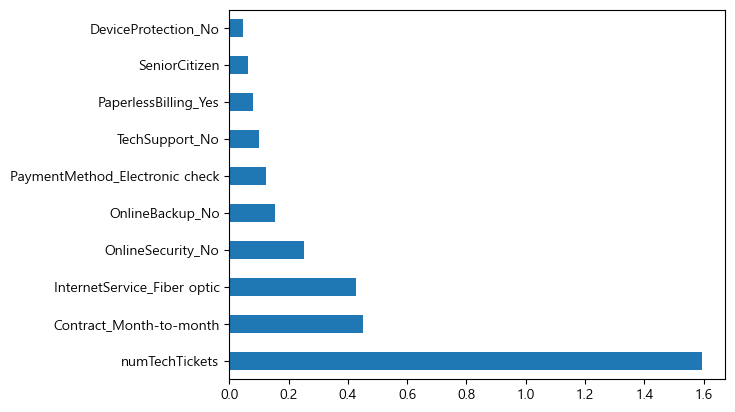

In [248]:
# 회귀 계수 확인
# coefficients = pipeline['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용
coefficients = gs.best_estimator_['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용

# 피처 이름과 계수 매핑
coef_series = pd.Series(coefficients, index=column_names)

print(coef_series.loc['tenure'])
# 결과 출력 (계수 값 기준 정렬 등)
coef_series.sort_values(ascending=False)[:10].plot(kind="barh");


이 위까지 one-hot encoding 후 linear regression

2. Randomforest

In [253]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [254]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
randomforest_feature_name = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [255]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("model", RandomForestClassifier(max_depth=16, random_state=42) )
])

params = {
    "model__max_depth": [11, 12, 13],
    "model__n_estimators": [90, 100, 110],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4, 6, 8]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [11, 12, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], 'model__n_estimators': [90, 100, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [256]:
print(gs.best_score_)
print(gs.best_params_)

0.8538446539582043
{'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [258]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [259]:
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

train
정확도: 0.9596743657705414
재현율: 0.9179743223965763
정밀도: 0.9292418772563177
F1 점수: 0.9235737351991389
Average Precision: 0.9752523780322906
ROC-AUC Score: 0.9915207656220127
test
정확도: 0.8512208972174901
재현율: 0.6488222698072805
정밀도: 0.7556109725685786
F1 점수: 0.6981566820276498
Average Precision: 0.8045045641071308
ROC-AUC Score: 0.9169226110296576


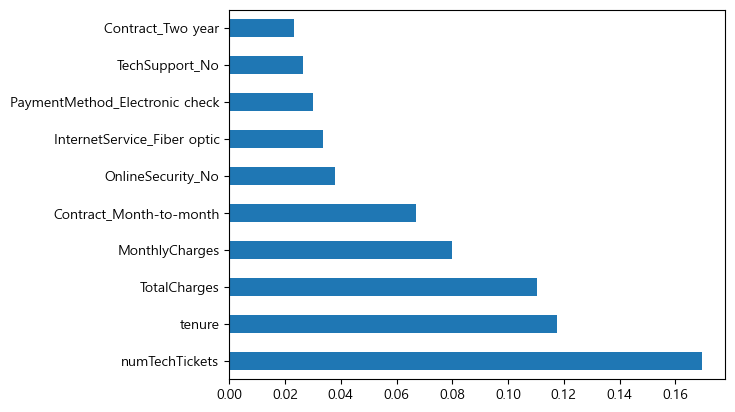

In [260]:
randomforest_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=randomforest_feature_name).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");


여기까지 원핫인코딩 후 randomforest. y는 label

3. decision tree

In [263]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [264]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
decision_feature_name = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [265]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ("model", DecisionTreeClassifier(max_depth=8, random_state=42) )
])

params = {
    "model__max_depth": [11, 12, 13],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4, 6, 8]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [11, 12, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [266]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [267]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.8987126088602801
재현율: 0.7624821683309557
정밀도: 0.8410700236034618
F1 점수: 0.799850355405911
Average Precision: 0.9070518581593674
ROC-AUC Score: 0.9642955755400974


In [268]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8438387279954571
재현율: 0.6702355460385439
정밀도: 0.7211981566820277
F1 점수: 0.6947835738068813
Average Precision: 0.7058679689890119
ROC-AUC Score: 0.8710636143094963


In [269]:
print(gs.best_score_)
print(gs.best_params_)

0.8318805484825545
{'model__max_depth': 13, 'model__min_samples_leaf': 8, 'model__min_samples_split': 2}


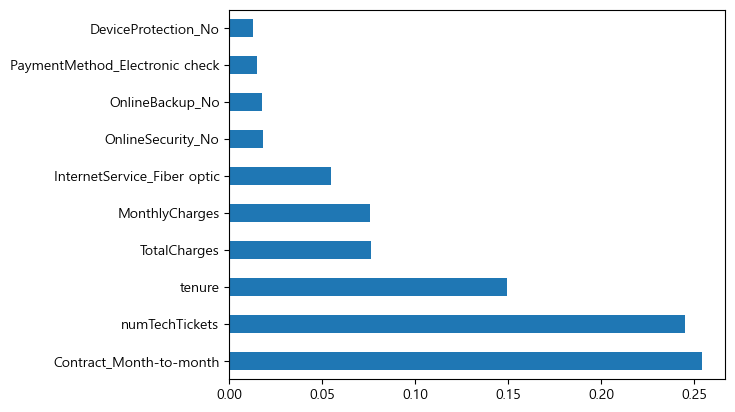

In [270]:
decision_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=decision_feature_name).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");

4. SVM

In [276]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [277]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [278]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# SVM : Feature scaling/One Hot Encoding 전처리.
pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm", SVC(random_state=0, probability=True)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    "svm__kernel": ["linear", "rbf",  "poly", "sigmoid"],
    "svm__C": [1.2, 1.3, 1.4], 
    "svm__gamma": [0.01, 0.02], 
}

gs = GridSearchCV(
    pipeline, 
    params,
    scoring=["accuracy", "roc_auc", "average_precision"], 
    refit="accuracy",
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'svm__C': [1.2, 1.3, ...], 'svm__gamma': [0.01, 0.02], 'svm__kernel': ['linear', 'rbf', ...]}"
,scoring,"['accuracy', 'roc_auc', ...]"
,n_jobs,-1
,refit,'accuracy'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [279]:
print(gs.best_score_, gs.best_params_)

0.8559241162571972 {'svm__C': 1.3, 'svm__gamma': 0.01, 'svm__kernel': 'linear'}


In [280]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [281]:
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

train
정확도: 0.857061719045816
재현율: 0.702567760342368
정밀도: 0.7445200302343159
F1 점수: 0.7229357798165138
Average Precision: 0.8156656303234376
ROC-AUC Score: 0.9203777372531141
test
정확도: 0.8642816581487791
재현율: 0.69593147751606
정밀도: 0.7701421800947867
F1 점수: 0.7311586051743532
Average Precision: 0.8301595390922609
ROC-AUC Score: 0.9259587157329663


In [289]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    gs.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, scoring='f1'
)

numTechTickets  : 0.224 +/- 0.014
tenure          : 0.174 +/- 0.012
TotalCharges    : 0.039 +/- 0.006
Contract_Two year : 0.026 +/- 0.006
Contract_Month-to-month : 0.021 +/- 0.005
InternetService_Fiber optic : 0.010 +/- 0.011
PaymentMethod_Electronic check : 0.004 +/- 0.004
numAdminTickets : 0.003 +/- 0.001
OnlineBackup_No : 0.002 +/- 0.003
PhoneService_No : 0.002 +/- 0.001
MultipleLines_No phone service : 0.002 +/- 0.001
PhoneService_Yes : 0.002 +/- 0.001
PaymentMethod_Mailed check : 0.001 +/- 0.002
OnlineSecurity_No : 0.001 +/- 0.005
TechSupport_No  : 0.001 +/- 0.002
DeviceProtection_No internet service : 0.001 +/- 0.001
InternetService_No : 0.001 +/- 0.001
OnlineSecurity_No internet service : 0.001 +/- 0.001
StreamingTV_No internet service : 0.001 +/- 0.001
TechSupport_No internet service : 0.001 +/- 0.001
OnlineBackup_No internet service : 0.001 +/- 0.001
StreamingMovies_No internet service : 0.001 +/- 0.001
DeviceProtection_No : 0.000 +/- 0.002
Contract_One year : 0.000 +/- 0.004


C:\Users\Playdata\AppData\Local\Temp\ipykernel_20840\1032942441.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])


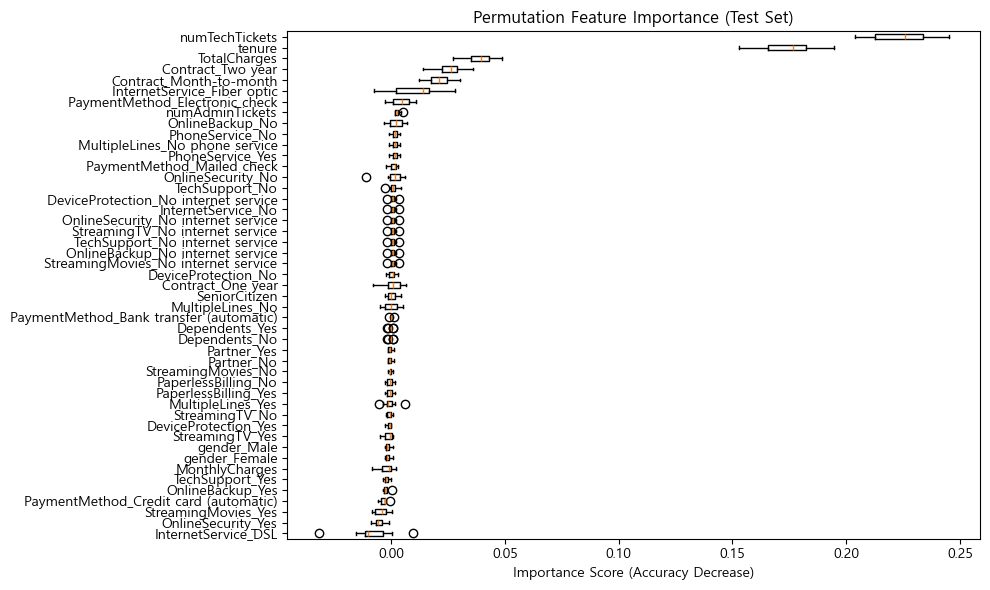

In [ ]:
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]: # 내림차순 출력
    print(f"{feature_names[i]:<15} : {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.xlabel("Importance Score (Accuracy Decrease)")
plt.tight_layout()
plt.show()


numTechTickets  : 0.237 +/- 0.013
tenure          : 0.230 +/- 0.016
TotalCharges    : 0.067 +/- 0.006
Contract_Two year : 0.053 +/- 0.009
Contract_Month-to-month : 0.041 +/- 0.008
InternetService_Fiber optic : 0.010 +/- 0.011
PaymentMethod_Electronic check : 0.006 +/- 0.006
OnlineBackup_No : 0.006 +/- 0.004
OnlineSecurity_No : 0.006 +/- 0.006
StreamingTV_No internet service : 0.002 +/- 0.002
DeviceProtection_No internet service : 0.002 +/- 0.002
StreamingMovies_No internet service : 0.002 +/- 0.002
TechSupport_No internet service : 0.002 +/- 0.002
OnlineBackup_No internet service : 0.002 +/- 0.002
InternetService_No : 0.002 +/- 0.002
OnlineSecurity_No internet service : 0.002 +/- 0.002
PhoneService_No : 0.002 +/- 0.001
PhoneService_Yes : 0.002 +/- 0.001
MultipleLines_No phone service : 0.002 +/- 0.001
numAdminTickets : 0.001 +/- 0.002
TechSupport_No  : 0.001 +/- 0.003
DeviceProtection_No : 0.001 +/- 0.002
PaymentMethod_Bank transfer (automatic) : 0.000 +/- 0.001
PaymentMethod_Mailed ch

C:\Users\Playdata\AppData\Local\Temp\ipykernel_20840\360947510.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])


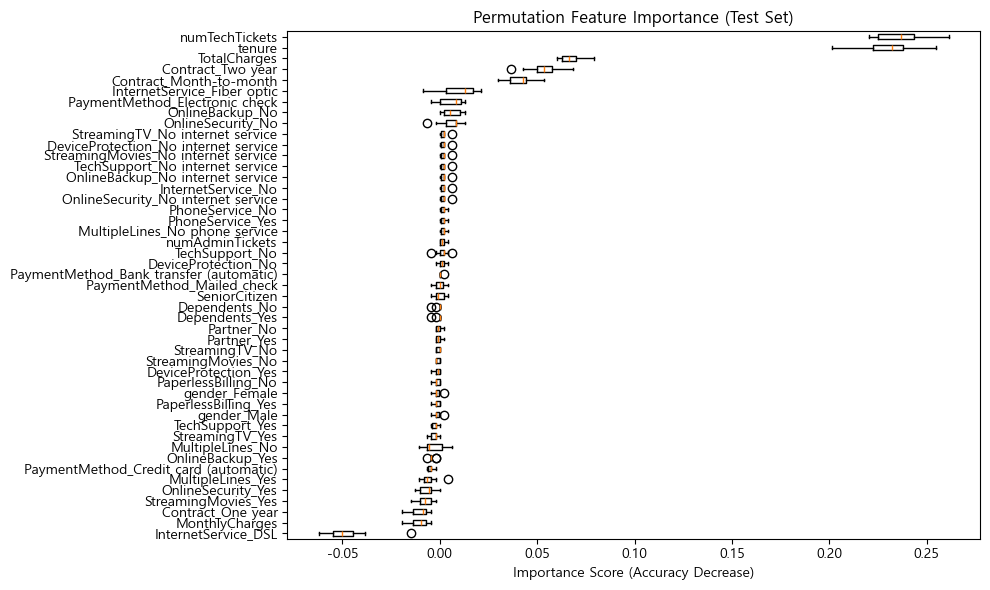

In [291]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    gs.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, scoring='recall'
)
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]: # 내림차순 출력
    print(f"{feature_names[i]:<15} : {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.xlabel("Importance Score (Accuracy Decrease)")
plt.tight_layout()
plt.show()


5. XGboost

In [319]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [320]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
xgb_feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

 GridSearchCV 이용

In [323]:
import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("xgb", XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    "xgb__n_estimators": [200, 300, 400],
    "xgb__learning_rate": [0.04, 0.05, 0.06], 
    "xgb__max_depth": [3, 4, 5],
    "xgb__gamma": [0.3, 0.4, 0.5]
}

gs = GridSearchCV(
    pipeline, 
    params,
    scoring=["f1", "recall"], 
    refit="f1",
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__gamma': [0.3, 0.4, ...], 'xgb__learning_rate': [0.04, 0.05, ...], 'xgb__max_depth': [3, 4, ...], 'xgb__n_estimators': [200, 300, ...]}"
,scoring,"['f1', 'recall']"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [324]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)
print(gs.best_score_, gs.best_params_)

0.7297945472601503 {'xgb__gamma': 0.4, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__n_estimators': 300}


train
정확도: 0.8871639530480878
재현율: 0.7553495007132668
정밀도: 0.8071646341463414
F1 점수: 0.7803979366249079
Average Precision: 0.8938230815095652
ROC-AUC Score: 0.9539816094827713
test
정확도: 0.8625780806360023
재현율: 0.6809421841541756
정밀도: 0.7737226277372263
F1 점수: 0.724373576309795
Average Precision: 0.8349934459151099
ROC-AUC Score: 0.9320136753720847


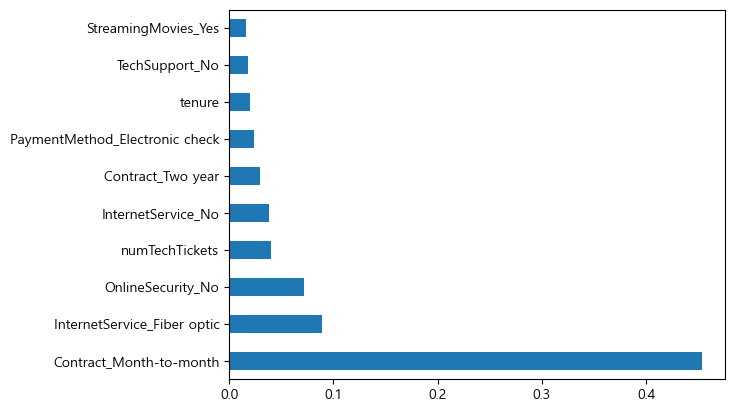

In [325]:
from metrics import print_binary_classification_metrics
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])
importances = gs.best_estimator_['xgb'].feature_importances_
fi = pd.Series(importances, index=xgb_feature_names).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");

In [330]:
fi.sort_values(ascending=True)[:50]

StreamingTV_No internet service            0.000000
StreamingMovies_No internet service        0.000000
DeviceProtection_No internet service       0.000000
PhoneService_Yes                           0.000000
OnlineBackup_No internet service           0.000000
PaperlessBilling_Yes                       0.000000
TechSupport_No internet service            0.000000
OnlineSecurity_No internet service         0.000000
MultipleLines_No phone service             0.000000
Partner_Yes                                0.000000
Dependents_Yes                             0.000000
gender_Male                                0.000000
OnlineSecurity_Yes                         0.001312
PaymentMethod_Credit card (automatic)      0.004020
PhoneService_No                            0.004147
numAdminTickets                            0.004508
Partner_No                                 0.004774
PaymentMethod_Bank transfer (automatic)    0.005009
Dependents_No                              0.005578
MonthlyCharg